
Run this notebook in Google Colab to use tensorflow demo 's online model of Mask RCNN and run the complete pipeline demo.

Mask RCNN part adapted from https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import cv2

In [2]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


In [3]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric


TensorFlow 1.x selected.


In [4]:
tf.__version__

'1.15.2'

## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [5]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

In [6]:
session = tf.Session(graph=tf.Graph())

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [7]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' 
mdl = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Load an image
Utility functions for Constellations pipeline


In [15]:
# Function built using original tensorflow notebook for Mask RCNN
'''Returns segmenation masks using Mask-RCNN'''
def detect(np_image_string,width,height):
    num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

    num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
    detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
    detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
    detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
    instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
    ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
    processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
    segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
    return segmentations

In [8]:
# Function to generate outline of image given the image, segmentation masks and option to use unmased image i.e full = True
def outline(image,segmentations,full):
    if(not full):
        if(len(segmentations)>2):
            seg = segmentations[0] + segmentations[1] + segmentations[2]
        elif (len(segmentations)>1):
            seg = segmentations[0] + segmentations[1]
        else:
            seg = segmentations[0]
        seg[np.where(seg>0) ]=1
        for l in range(3):
            image[:,:,l]= image[:,:,l]*seg
        edges_out = cv2.Canny(seg,1,1)
    image = cv2.blur(image, (3,3))
    edges = cv2.Canny(image,80,200)
    edges = edges | edges_out
    return edges


In [9]:
def draw_circle_white(draw,c,dist):
    r = dist
    shape = [(c[0]-r,c[1]-r),(c[0]+r,c[1]+r)]
    draw.ellipse(shape,fill=250) 
def draw_circle_black(draw,c,dist):
    r = dist
    shape = [(c[0]-r,c[1]-r),(c[0]+r,c[1]+r)]
    draw.ellipse(shape,fill=0) 

'''Function to generate a dotted image from an outline'''    
def generate_image_dotted(edges,dist=40,dot= 2):
    im = Image.fromarray(edges)
    # create rectangle image 
    draw = ImageDraw.Draw(im)   
    img_shape = edges.shape
    px = im.load()
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if(px[j,i]==255):
                draw_circle_black(draw,(j,i),dist)
                px[j,i]=255
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if(px[j,i]==255):
                draw_circle_white(draw,(j,i),dot)
    return im
'''Function to add noise with a particular value of probability, Prob (p)'''
def add_noise(im,prob = 0.0001,dot =2 ):
    draw = ImageDraw.Draw(im)
    img_shape = np.array(im).shape
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if(np.random.random()<prob):
                draw_circle_white(draw,(j,i),dot)
    return np.array(im)



In [10]:
'''Save image to specifc type folder and image'''
def save_image(image, base_folder, image_type, image_name):
    if not os.path.isdir(base_folder+'/'+image_type):
        os.mkdir(folder_path+'/'+image_type)
    plt.imsave(folder_path+'/'+image_type+'/'+image_name+'.jpg',image,cmap='gray')

## Demo of generating constellation images on an online image

In [11]:
! wget -O apple.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZrytwwORdNJugtXOlOKjWi7yaop3Rf2_qbA&usqp=CAU


--2022-04-01 10:57:57--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZrytwwORdNJugtXOlOKjWi7yaop3Rf2_qbA
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.130.102, 74.125.130.138, 74.125.130.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.130.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4872 (4.8K) [image/jpeg]
Saving to: ‘apple.jpg’

apple.jpg           100%[===================>]   4.76K  --.-KB/s    in 0s      

2022-04-01 10:57:57 (65.4 MB/s) - ‘apple.jpg’ saved [4872/4872]



In [16]:
with open('apple.jpg', 'rb') as f:
    np_image_string = np.array([f.read()])
image = Image.open('apple.jpg')
width, height = image.size

In [17]:
segmentations = detect(np_image_string,width,height)

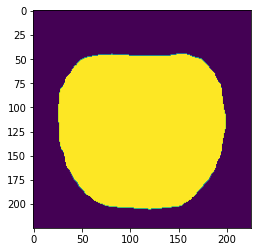

In [18]:
plt.imshow(segmentations[2])

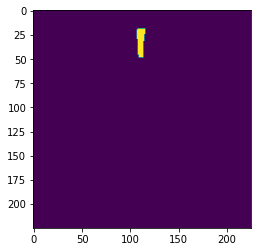

In [19]:
plt.imshow(segmentations[0])

In [20]:
# Choices for the best outline shall be made here, some cleaning is done manually if needed
image = np.array(image)
seg = segmentations[0] + segmentations[1] + segmentations[2] # one may have to chose 1,2 or 3 shapes here
seg[np.where(seg>0) ]=1
for l in range(3):
    image[:,:,l]= image[:,:,l]*seg
edges_out = cv2.Canny(seg,1,1) # segment outer edge, some images may look better not including this
image = cv2.blur(image, (3,3))
edges = cv2.Canny(image,80,200) # the parameters of this is one choice that user may have to make
edges = edges | edges_out # again some images may look better without the outser edge

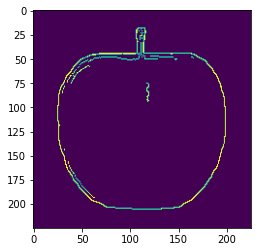

In [21]:
plt.imshow(edges)

## Generate dotted image

In [22]:
dotted = generate_image_dotted(edges,10,2) # the two parameters here should be controlled i.e distance between dots 'd' , radius of dots


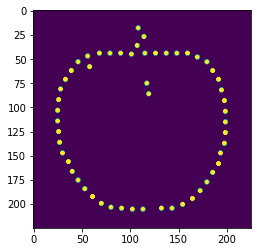

In [23]:
plt.imshow(dotted)

## add noise

In [24]:
final = add_noise(dotted,prob = 0.001,dot =2 ) # two paramters here, probability of noise ('p') , diameter of dots (will remian same as above)

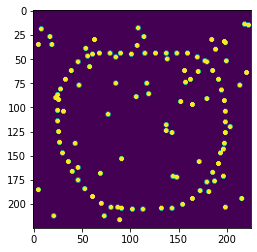

In [25]:
plt.imshow(final)